In [641]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [642]:
# load state data
state_df = pd.read_csv('../data/states.csv')

# drop all entries of Year_Semester including the word "Summer"
state_df = state_df[~state_df['Year_Semester'].str.contains('Summer')]

# drop all entries in Year_Semester prior to Fall 2021
cutoff = state_df[state_df['Year_Semester'] == 'Spring 2020']['Semester_Num'].values[0]
state_df = state_df[state_df['Semester_Num'] >= cutoff]

state_df

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester
4,3,10100,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Spring 2020
6,3,10104,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Fall 2020
7,3,10105,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Spring 2021
9,3,10109,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Fall 2021
10,3,10110,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Spring 2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84834,2186,10120,0,0,1,1,1,1,1,1,1,3,3,0,1,1,1,Spring 2024
84836,6481,10114,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Fall 2022
84837,6481,10115,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Spring 2023
84839,6481,10119,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Fall 2023


In [643]:
display(state_df[state_df['CSCI200'] == 2])
display(state_df[state_df['id'] == 3506])

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester


,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester
77705,3506,10104,0,0,1,1,1,1,1,1,1,3,3,-1,0,1,1,Fall 2020
77706,3506,10105,0,-2,-1,-1,1,-1,1,1,1,3,3,-1,-1,0,1,Spring 2021
77708,3506,10109,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Fall 2021
77709,3506,10110,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Spring 2022
77711,3506,10114,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Fall 2022
77712,3506,10115,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Spring 2023
77714,3506,10119,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Fall 2023
77715,3506,10120,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Spring 2024


In [644]:
classes = ['CSCI128', 'CSCI200', 'CSCI220', 'CSCI274',
       'CSCI306', 'CSCI341', 'CSCI358', 'CSCI370', 'CSCI400', 'CSCI406',
       'CSCI442', 'MATH111', 'MATH112', 'MATH213', 'MATH332']

In [645]:
min_values = [state_df[c].min() for c in classes]
max_values = [state_df[c].max() for c in classes]
global_min = min(min_values)
global_max = max(max_values)

# normalize the data
if (global_max - global_min) < 10: 
    for c in classes:
        state_df[c] = state_df[c] - global_min
else: 
    print("ERROR: signature range is too large")

# set variables to count 
eligible = -1 * global_min

In [646]:
# create column concatenating all columns in classes
state_df['signature'] = state_df[classes].apply(lambda x: ''.join(x.astype(str)), axis=1)

# get list of all signatures
signatures = state_df['signature'].unique()


In [647]:
# create two networks: one showing Fall to Spring transitions, another showing Spring to Fall transitions
G_all = nx.DiGraph()

# add nodes to graph
G_all.add_nodes_from(signatures)

# add 0 weight edges between nodes
for s1 in signatures:
    for s2 in signatures:
        G_all.add_edge(s1, s2, weight=0)
        G_all.add_edge(s2, s1, weight=0)

In [648]:
for id in state_df['id'].unique(): 
    id_df = state_df[state_df['id'] == id]

    # get list in order of signatures
    sigs = id_df['signature'].tolist()

    # add 1 to weight of edge between each pair of signatures
    for i in range(len(sigs) - 1): 
        G_all[sigs[i]][sigs[i+1]]['weight'] += 1
    

In [649]:
# based on graph, create Markov chain matrix
weighted_adj_matrix = nx.to_numpy_array(G_all, weight='weight')

# Normalize the weighted adjacency matrix
row_sums = weighted_adj_matrix.sum(axis=1, keepdims=True)
# Avoid division by zero for rows that sum to zero
row_sums[row_sums == 0] = 1
normalized_adj_matrix = weighted_adj_matrix / row_sums

# Calculating State Changes

In [650]:
def get_state_vector(year_semester):
    spring23_df = state_df[state_df['Year_Semester'] == year_semester]

    # reduce spring23_df to include counts of signatures
    spring23_df = spring23_df.groupby('signature').size().reset_index(name='count')

    # Ensure the DataFrame is ordered to match the Markov matrix
    df_ordered = spring23_df.set_index('signature').reindex(signatures).reset_index()

    # Now, df_ordered['count'] can be directly used as the state vector
    state_vector = df_ordered['count'].fillna(0).to_numpy()

    return state_vector

In [651]:
def count_taken(vector): 
    # create count dictionary
    count_dict = {cl:0 for cl in classes}

    for i in range(len(vector)):
        sig = signatures[i]
        for index,digit in enumerate(str(sig)): 
            if int(digit) < eligible: 
                count_dict[classes[index]] += vector[i]

    return count_dict

In [652]:
def get_enrollment(year_semester): 
    NUM_LIST = ['Cap', 'Act', 'Rem', 'WL Cap','WL Act','WL Rem','XL Cap','XL Act','XL Rem']
    CORE_LIST = ['128', '200', '220', '274', '306', '341', '358', '370', '400', '406', '442']

    # load schedule data
    name = year_semester.split(" ")[0] + year_semester.split(" ")[1][2:]
    schedule_df = pd.read_csv(f'../schedules/{name}.csv')

    # remove 102 entries
    df = schedule_df[schedule_df['Title'] != 'INTRODUCTION TO COMPUTER SCIENCE - LAB']

    # change CrseNum to string
    df['CrseNum'] = df['CrseNum'].astype(str)

    # replace equivalent classes
    df['CrseNum'] = df['CrseNum'].replace('101', '128')
    df['CrseNum'] = df['CrseNum'].replace('261', '200')
    df['CrseNum'] = df['CrseNum'].replace('262', '220')

    # replace equivalent course names
    df['Title'] = df['Title'].replace('INTRODUCTION TO COMPUTER SCIENCE', 'COMPUTER SCIENCE FOR STEM')
    df['Title'] = df['Title'].replace('PROGRAMMING CONCEPTS', 'FOUNDATIONAL PROGRAMMING CONCEPTS & DESIGN')
    df['Title'] = df['Title'].replace('DATA STRUCTURES', 'DATA STRUCTURES AND ALGORITHMS')

    # filter to only CrseNum in CORE_LIST
    df = df[df['CrseNum'].isin(CORE_LIST)]

    # set all columns in NUM_LIST to int
    for col in NUM_LIST:
        df.loc[:,col] = df[col].astype(int)

    # group by class and year
    core_df = df.groupby(['CrseNum','Title']).sum().reset_index()

    return core_df

In [653]:
def find_actual_pass(year_semester): 
    actual_df = pd.read_csv(f'../data/combined.csv')
    actual_df = actual_df[actual_df['Year_Semester'] == year_semester][['Class','Taken']]

    # convert actual_df into dictionary
    actual_dict = actual_df.set_index('Class').to_dict()['Taken']

    if 'CSCI370' not in actual_dict: 
        actual_dict['CSCI370'] = 0

    return actual_dict

In [654]:
semesters_list = ['Spring 2020', 'Fall 2021', 'Spring 2022', 'Fall 2022', 'Spring 2023', 'Fall 2023']

In [655]:
# create storage df
results_df = pd.DataFrame(columns=['year_semester', 'class', 'difference', 'true', 'predicted pass', 'actual enrollment', 'capacity'])

# just cs classes
cs_classes = [cl for cl in classes if cl[:4] == 'CSCI']

# get predictions
for index in range(1, len(semesters_list)):

    # get predicted passes
    state_vector = get_state_vector(semesters_list[index-1])
    predicted_fall23 = state_vector @ normalized_adj_matrix
    predicted_count_dict = count_taken(predicted_fall23)

    # get actual passes
    actual_count_dict = find_actual_pass(semesters_list[index])

    # get previous semester
    prev_count_dict = count_taken(state_vector)

    # get enrollment
    enrollment = get_enrollment(semesters_list[index])

    # find difference prev and true
    true_comparison_dict = {cl: actual_count_dict[cl] for cl in cs_classes}

    # find difference prev and predicted
    predicted_comparison_dict = {cl: predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

    # find error between true and predicted
    error_dict = {cl: actual_count_dict[cl] - predicted_comparison_dict[cl] for cl in cs_classes}

    # find difference true and predicted
    print(f"PREDICTIONS FOR {semesters_list[index].upper()}")
    for cl in cs_classes: 
        enroll_value = enrollment[enrollment['CrseNum'] == cl[4:]]['Act'].values[0]

        capacity = enrollment[enrollment['CrseNum'] == cl[4:]]['Cap'].values[0]

        # add results to results_df
        results_df = pd.concat([results_df, pd.DataFrame([[semesters_list[index], cl, error_dict[cl], true_comparison_dict[cl], predicted_comparison_dict[cl], enroll_value, capacity]], 
                                                         columns=['year_semester', 'class', 'difference', 'true', 'predicted pass', 'actual enrollment', 'capacity'])])


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

PREDICTIONS FOR FALL 2021
PREDICTIONS FOR SPRING 2022
PREDICTIONS FOR FALL 2022
PREDICTIONS FOR SPRING 2023
PREDICTIONS FOR FALL 2023


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [656]:
# calculate pass rate
results_df['pass rate'] = (results_df['true'] + 0.00000001 )/ (results_df['actual enrollment'] + 0.00000001)

In [657]:
# average error and pass rates across all semesters
grouped_df = results_df.drop(columns=['year_semester']).groupby('class').mean().reset_index()

In [658]:
# find predicted enrollment based on historical pass rate
results_df['predicted enrollment'] = results_df['predicted pass'] / results_df['pass rate']
results_df['error'] = (results_df['predicted enrollment'] - results_df['actual enrollment']) / (results_df['actual enrollment'] + 0.00000001)
display(results_df)

,year_semester,class,difference,true,predicted pass,actual enrollment,capacity,pass rate,predicted enrollment,error
0,Fall 2021,CSCI128,155.174535,408,252.825465,474,486,0.860759,293.723702,-0.38033
0,Fall 2021,CSCI200,2.384668,173,170.615332,209,243,0.827751,206.1191,-0.013784
0,Fall 2021,CSCI220,176.344661,254,77.655339,566,619,0.448763,173.043,-0.69427
0,Fall 2021,CSCI274,157.367159,223,65.632841,250,275,0.892,73.579418,-0.705682
0,Fall 2021,CSCI306,55.266822,150,94.733178,158,180,0.949367,99.785615,-0.368445
0,Fall 2021,CSCI341,77.608733,157,79.391267,183,199,0.857923,92.538865,-0.494323
0,Fall 2021,CSCI358,68.789408,138,69.210592,157,164,0.878981,78.739587,-0.498474
0,Fall 2021,CSCI370,12.140805,78,65.859195,83,84,0.939759,70.080938,-0.155651
0,Fall 2021,CSCI400,69.140641,123,53.859359,132,123,0.931818,57.800288,-0.562119
0,Fall 2021,CSCI406,60.014588,114,53.985412,128,130,0.890625,60.6152,-0.526444


In [659]:
grouped_df = results_df.drop(columns=['year_semester']).groupby('class').mean().reset_index()
display(grouped_df)

,class,difference,true,predicted pass,actual enrollment,capacity,pass rate,predicted enrollment,error
0,CSCI128,30.916528,536.8,505.883472,594.8,619.2,0.898864,560.535998,-0.042764
1,CSCI200,-26.464682,218.0,244.464682,271.2,283.6,0.801227,304.668295,0.119398
2,CSCI220,-1.581321,184.2,185.781321,297.8,342.2,0.698192,275.469505,0.099323
3,CSCI274,9.216427,169.6,160.383573,186.8,207.0,0.906622,176.047568,0.019372
4,CSCI306,10.989578,159.4,148.410422,165.2,197.6,0.964025,153.947526,-0.055624
5,CSCI341,1.842651,144.4,142.557349,154.6,168.0,0.942406,156.664005,0.032544
6,CSCI358,40.002194,161.2,121.197806,177.0,184.2,0.909794,132.927129,-0.26397
7,CSCI370,-46.991806,61.0,107.991806,62.4,63.8,0.984423,109.296686,4306502130.520632
8,CSCI400,26.148922,130.0,103.851078,138.4,145.2,0.935254,110.916388,-0.180611
9,CSCI406,51.921409,145.2,93.278591,162.4,162.8,0.894203,104.087654,-0.36545


In [660]:
# split year semester into year and semester
results_df['year'] = results_df['year_semester'].apply(lambda x: x.split(" ")[1])
results_df['semester'] = results_df['year_semester'].apply(lambda x: x.split(" ")[0])

semester_grouped_df = results_df.drop(columns=['year', 'year_semester']).groupby(['class', 'semester']).mean().reset_index()

In [661]:
display(semester_grouped_df)

,class,semester,difference,true,predicted pass,actual enrollment,capacity,pass rate,predicted enrollment,error
0,CSCI128,Fall,148.387062,558.0,409.612938,616.0,644.0,0.900424,451.410471,-0.261516
1,CSCI128,Spring,-145.289272,505.0,650.289272,563.0,582.0,0.896525,724.224289,0.285363
2,CSCI200,Fall,-13.933466,227.0,240.933466,276.333333,292.666667,0.820703,293.357531,0.05376
3,CSCI200,Spring,-45.261506,204.5,249.761506,263.5,270.0,0.772014,321.63444,0.217856
4,CSCI220,Fall,45.178259,211.333333,166.155074,332.666667,360.333333,0.733193,216.754622,-0.16458
5,CSCI220,Spring,-71.720691,143.5,215.220691,245.5,315.0,0.64569,363.541828,0.495179
6,CSCI274,Fall,51.073680,194.333333,143.259653,211.666667,225.0,0.919873,154.184388,-0.233294
7,CSCI274,Spring,-53.569453,132.5,186.069453,149.5,180.0,0.886746,208.842338,0.398371
8,CSCI306,Fall,5.448323,153.666667,148.218344,161.0,192.666667,0.95425,155.22924,-0.038748
9,CSCI306,Spring,19.301462,168.0,148.698538,171.5,205.0,0.978687,152.024954,-0.080937


# Spring 24 Enrollment

In [662]:
# load spring2024 data
schedule_df = pd.read_csv('../schedules/Spring24.csv')
schedule_df['CrseNum'] = schedule_df['CrseNum'].astype(str)

# display(schedule_df)

capacity_dict = {cl: schedule_df[schedule_df['CrseNum'] == str(cl[4:])]['Cap'].sum() for cl in cs_classes if str(cl[4:]) in schedule_df['CrseNum'].unique()}

In [663]:
state_vector = get_state_vector('Fall 2023')
predicted_spring2024 = state_vector @ normalized_adj_matrix
predicted_count_dict = count_taken(predicted_spring2024)

# get Fall 2023 actual passes
prev_count_dict = count_taken(state_vector)

# get enrollment
enrollment = get_enrollment('Spring 2024')

# find difference prev and predicted
predicted_comparison_dict = {cl: predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

# find difference between enrollment and predicted
print(f"PREDICTIONS FOR SPRING 2024")
for cl in cs_classes: 
    enroll_value = enrollment[enrollment['CrseNum'] == cl[4:]]['Act'].values[0]

    predicted_enrollment = predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]

    print(f"{cl}")
    print(f"\tPREDICTED ENROLL: {predicted_enrollment}")
    print(f"\tENROLLMENT: {enroll_value}")
    print(f"\tCAPACITY: {enrollment[enrollment['CrseNum'] == cl[4:]]['Cap'].values[0]}")
    print(f"\tERROR: {(predicted_enrollment - enroll_value) / enroll_value}")
    print()

    # add to results_df
    results_df = pd.concat([results_df, pd.DataFrame([['Spring 2024', cl, 0, 0, 
                                                       predicted_comparison_dict[cl], enroll_value, 
                                                       capacity_dict[cl], 0,
                                                       predicted_enrollment, (predicted_enrollment - enroll_value) / enroll_value, 
                                                       '2024', 'Spring']], 
                                                     columns=['year_semester', 'class', 'difference', 'true', 
                                                               'predicted pass','actual enrollment', 
                                                               'capacity', 'pass rate', 
                                                               'predicted enrollment','error', 
                                                               'year', 'semester'])])

PREDICTIONS FOR SPRING 2024
CSCI128
	PREDICTED ENROLL: 541.4523550352136
	ENROLLMENT: 572
	CAPACITY: 610
	ERROR: -0.05340497371466154

CSCI200
	PREDICTED ENROLL: 502.28118569591925
	ENROLLMENT: 302
	CAPACITY: 300
	ERROR: 0.6631827340924479

CSCI220
	PREDICTED ENROLL: 441.89500820754137
	ENROLLMENT: 200
	CAPACITY: 220
	ERROR: 1.2094750410377069

CSCI274
	PREDICTED ENROLL: 294.80358516357757
	ENROLLMENT: 106
	CAPACITY: 150
	ERROR: 1.7811658977695997

CSCI306
	PREDICTED ENROLL: 189.66842080667772
	ENROLLMENT: 168
	CAPACITY: 180
	ERROR: 0.12897869527784356

CSCI341
	PREDICTED ENROLL: 202.74119917540096
	ENROLLMENT: 170
	CAPACITY: 170
	ERROR: 0.1925952892670645

CSCI358
	PREDICTED ENROLL: 180.1486101764344
	ENROLLMENT: 194
	CAPACITY: 210
	ERROR: -0.07139891661631752

CSCI370
	PREDICTED ENROLL: 142.4824286113456
	ENROLLMENT: 0
	CAPACITY: 0
	ERROR: inf

CSCI400
	PREDICTED ENROLL: 143.43594072768383
	ENROLLMENT: 111
	CAPACITY: 140
	ERROR: 0.29221568223138583

CSCI406
	PREDICTED ENROLL: 131.980

/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1948926589.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"\tERROR: {(predicted_enrollment - enroll_value) / enroll_value}")
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1948926589.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  predicted_enrollment, (predicted_enrollment - enroll_value) / enroll_value,


In [664]:
# simple grouped_df for merging
simple_grouped_df = semester_grouped_df[['class', 'error', 'semester']]

# adjust predictions with average error for that class
results_df = results_df.merge(simple_grouped_df, on=['class', 'semester'], how='left', suffixes=('', ' avg'))

In [665]:
results_df['error_corrected_predicted_enrollment'] = results_df['predicted enrollment'] - results_df['error avg'] * results_df['predicted enrollment']
results_df['error_corrected_error'] = (results_df['error_corrected_predicted_enrollment'] - results_df['actual enrollment'] + 0.00001) / (results_df['actual enrollment'] + 0.00001)

# Fall 2024 Enrollment

In [666]:
pass_rate_list = [grouped_df[grouped_df['class'] == cl]['pass rate'].values[0] for cl in cs_classes]

In [667]:
# state vector is just the S2024 predictions
predicted_fall2024 = predicted_spring2024 @ normalized_adj_matrix
predicted_count_dict = count_taken(predicted_fall2024)

# find difference between predicted spring2024 and fall2024
prev_count_dict = count_taken(predicted_spring2024)

# find difference prev and predicted
predicted_comparison_dict = {cl: predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

# reverse pass rate
predicted_enrollment_dict = {cl: predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0] for cl in cs_classes}

# error correct 
error_corrected_predicted_enrollment_dict = {cl: predicted_enrollment_dict[cl] - semester_grouped_df[(semester_grouped_df['class'] == cl) & (semester_grouped_df['semester'] == 'Fall')]['error'].values[0] * predicted_enrollment_dict[cl] for cl in cs_classes}

print("FALL 2024 PREDICTIONS")
print(f"Raw predictions: \n{predicted_comparison_dict}")
print(f"Post-error correction and post-pass rate reversal: \n{error_corrected_predicted_enrollment_dict}")


FALL 2024 PREDICTIONS
Raw predictions: 
{'CSCI128': 127.24792705053915, 'CSCI200': 294.77025723285715, 'CSCI220': 273.509247416207, 'CSCI274': 248.43892093610998, 'CSCI306': 188.90908325841497, 'CSCI341': 206.3851630803524, 'CSCI358': 201.37998107922817, 'CSCI370': 130.03259801424292, 'CSCI400': 114.09091209538155, 'CSCI406': 114.58786935917021, 'CSCI442': 119.24406999273742}
Post-error correction and post-pass rate reversal: 
{'CSCI128': 178.58679461844338, 'CSCI200': 348.1202872302859, 'CSCI220': 456.2120678124922, 'CSCI274': 337.9557168587947, 'CSCI306': 203.55170115660212, 'CSCI341': 196.24946846711384, 'CSCI358': 273.11997874624046, 'CSCI370': 125.61749016947233, 'CSCI400': 165.14648011100513, 'CSCI406': 174.39050218736085, 'CSCI442': 152.43414856578957}


In [668]:
# find capacity
schedule_df = pd.read_csv(f'../schedules/Fall24.csv')
schedule_df['CrseNum'] = schedule_df['CrseNum'].astype(str)

# display(schedule_df)

capacity_dict = {cl: schedule_df[schedule_df['CrseNum'] == str(cl[4:])]['Cap'].sum() for cl in cs_classes if str(cl[4:]) in schedule_df['CrseNum'].unique()}
capacity_dict['CSCI274'] = 0 

capacity_list = [capacity_dict[cl] for cl in cs_classes]

In [669]:
# Length of your classes, to create constant columns
length = len(cs_classes)

average_error_dict = {cl: results_df[(results_df['class'] == cl) & (results_df['semester'] == 'Fall')]['error avg'].values[0] for cl in cs_classes}


# Construct the dictionary for the DataFrame
data = {
    'year_semester': ['Fall 2024'] * length,
    'class': list(cs_classes),
    'difference': [np.NAN] * length,
    'true': [np.NAN] * length,
    'predicted pass': [predicted_comparison_dict[cl] for cl in cs_classes],
    'actual enrollment':[np.NAN] * length,
    'capacity': capacity_list,
    'pass rate': [np.NAN] * length,
    'predicted enrollment': [predicted_enrollment_dict[cl] for cl in cs_classes],
    'error': [np.NAN] * length,
    'error avg': average_error_dict.values(),
    'error_corrected_predicted_enrollment': [error_corrected_predicted_enrollment_dict[cl] for cl in cs_classes],
    'error_corrected_error':[np.NAN] * length,
    'year': ['2024'] * length,
    'semester': ['Fall'] * length
}

# Convert the dictionary to a pandas DataFrame
fall24_df = pd.DataFrame(data)

In [670]:
results_df = pd.concat([results_df, fall24_df])

# Fix systemic error

# Pre-Error Correction

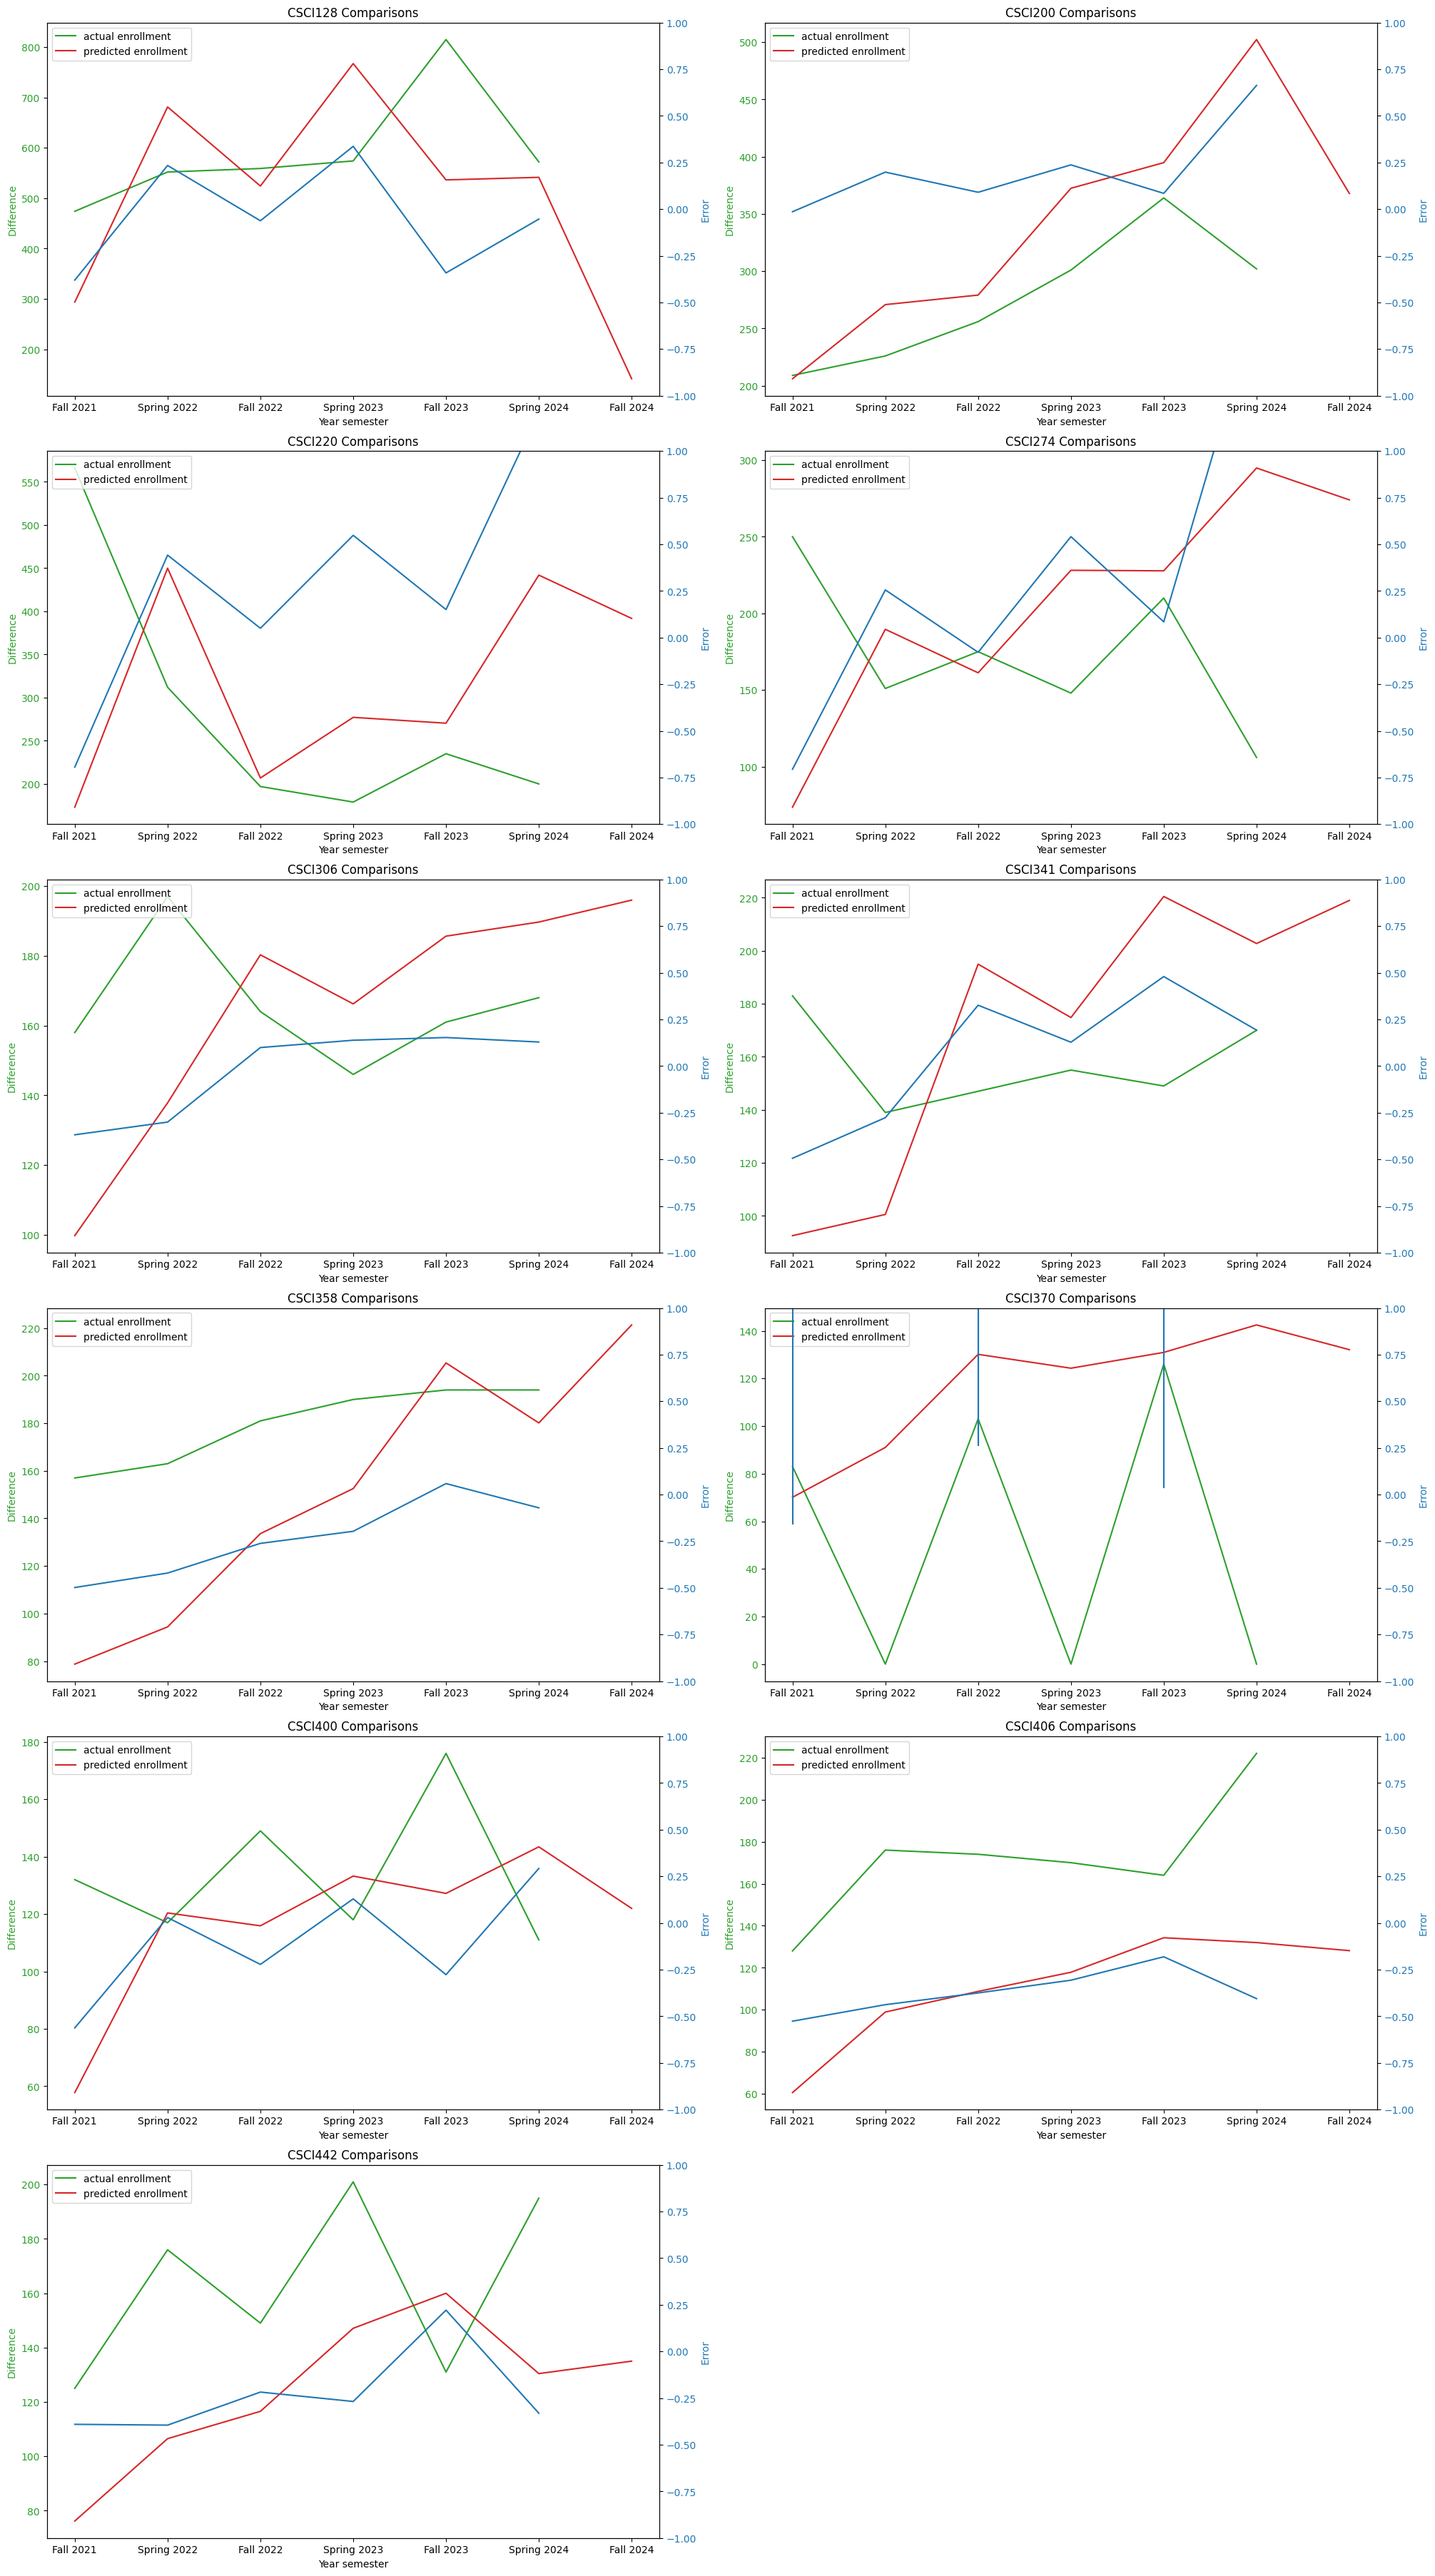

In [671]:
# Calculate the number of rows and columns for the subplot grid
num_classes = len(cs_classes)
num_rows = int(np.ceil(num_classes / 2))  # Adjust the divisor to change the number of columns

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()  # Flatten the array for easy iteration

for i, cl in enumerate(cs_classes):
    plot_df = results_df[results_df['class'] == cl]
    
    # Select the subplot for the current class
    ax1 = axs[i]

    # Plotting on the primary y-axis
    color = 'tab:green'
    ax1.set_xlabel('Year semester')
    ax1.set_ylabel('Difference', color=color)
    ax1.plot(plot_df['year_semester'], plot_df['actual enrollment'], color=color, label='actual enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['predicted enrollment'], color='tab:red', label='predicted enrollment')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Creating a secondary y-axis for the current subplot
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Error', color=color)
    ax2.plot(plot_df['year_semester'], plot_df['error'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-1, 1])

    # Set the title for the current subplot
    ax1.set_title(f"{cl} Comparisons")

# Hide unused subplots if the number of classes is odd
if num_classes % 2 != 0:
    axs[-1].axis('off')

plt.show()

# Post-Error Correction

In [717]:
# calculate fudge factor
results_df['fudge factor'] = 0.000

for cl in cs_classes:
    predictions = results_df[results_df['class'] == cl]['error_corrected_predicted_enrollment']
    actuals = results_df[results_df['class'] == cl]['actual enrollment']

    predictions_to_fit = predictions[2:-1]
    actuals_to_fit = actuals[2:-1]

    fudge = np.mean(actuals_to_fit) / np.mean(predictions_to_fit)

    results_df.loc[results_df['class'] == cl, 'fudge factor'] = fudge

# calculate with fudge
results_df['fudge_corrected_predicted_enrollment'] = results_df['error_corrected_predicted_enrollment'] * results_df['fudge factor']

In [723]:
# add upper and lower bound based on historical error
results_df['upper predicted enrollment'] = results_df['fudge_corrected_predicted_enrollment'] + (results_df['fudge_corrected_predicted_enrollment'] * (results_df['error avg'].abs()))
results_df['lower predicted enrollment'] = results_df['fudge_corrected_predicted_enrollment'] - (results_df['fudge_corrected_predicted_enrollment'] * (results_df['error avg'].abs()))

display(results_df[results_df['class'] == 'CSCI220'])

,year_semester,class,difference,true,predicted pass,actual enrollment,capacity,pass rate,predicted enrollment,error,year,semester,error avg,error_corrected_predicted_enrollment,error_corrected_error,upper predicted enrollment,lower predicted enrollment,fudge factor,fudge_corrected_predicted_enrollment
2,Fall 2021,CSCI220,176.344661,254,77.655339,566,619,0.448763,173.043000,-0.694270,2021,Fall,-0.164580,201.522488,-0.643953,207.167721,148.613159,0.882732,177.890440
13,Spring 2022,CSCI220,-57.925252,131,188.925252,312,420,0.419872,449.959378,0.442177,2022,Spring,0.495179,227.148983,-0.271958,299.800984,101.222575,0.882732,200.511779
24,Fall 2022,CSCI220,-8.164883,163,171.164883,197,222,0.827411,206.867988,0.050091,2022,Fall,-0.164580,240.914406,0.222916,247.663122,177.662807,0.882732,212.662964
35,Spring 2023,CSCI220,-85.516131,156,241.516131,179,210,0.871508,277.124279,0.548180,2023,Spring,0.495179,139.898180,-0.218446,184.643627,62.341701,0.882732,123.492664
46,Fall 2023,CSCI220,-32.644999,217,249.644999,235,240,0.923404,270.352879,0.150438,2023,Fall,-0.164580,314.847666,0.339777,323.667469,232.185037,0.882732,277.926253
57,Spring 2024,CSCI220,0.000000,0,308.527458,200,220,0.000000,441.895008,1.209475,2024,Spring,0.495179,223.077919,0.115390,294.427819,99.408419,0.882732,196.918119
2,Fall 2024,CSCI220,0.000000,0,273.509247,0,240,0.000000,391.739432,0.000000,2024,Fall,-0.164580,456.212068,0.000000,468.991900,336.434495,0.882732,402.713198


In [724]:
# set all instances of infinity error to 0
results_df['error_corrected_error'] = results_df['error_corrected_error'].replace([np.inf, -np.inf], 0)
results_df['error'] = results_df['error'].replace([np.inf, -np.inf], 0)

# replace all instances of nan with 0
results_df = results_df.fillna(0)

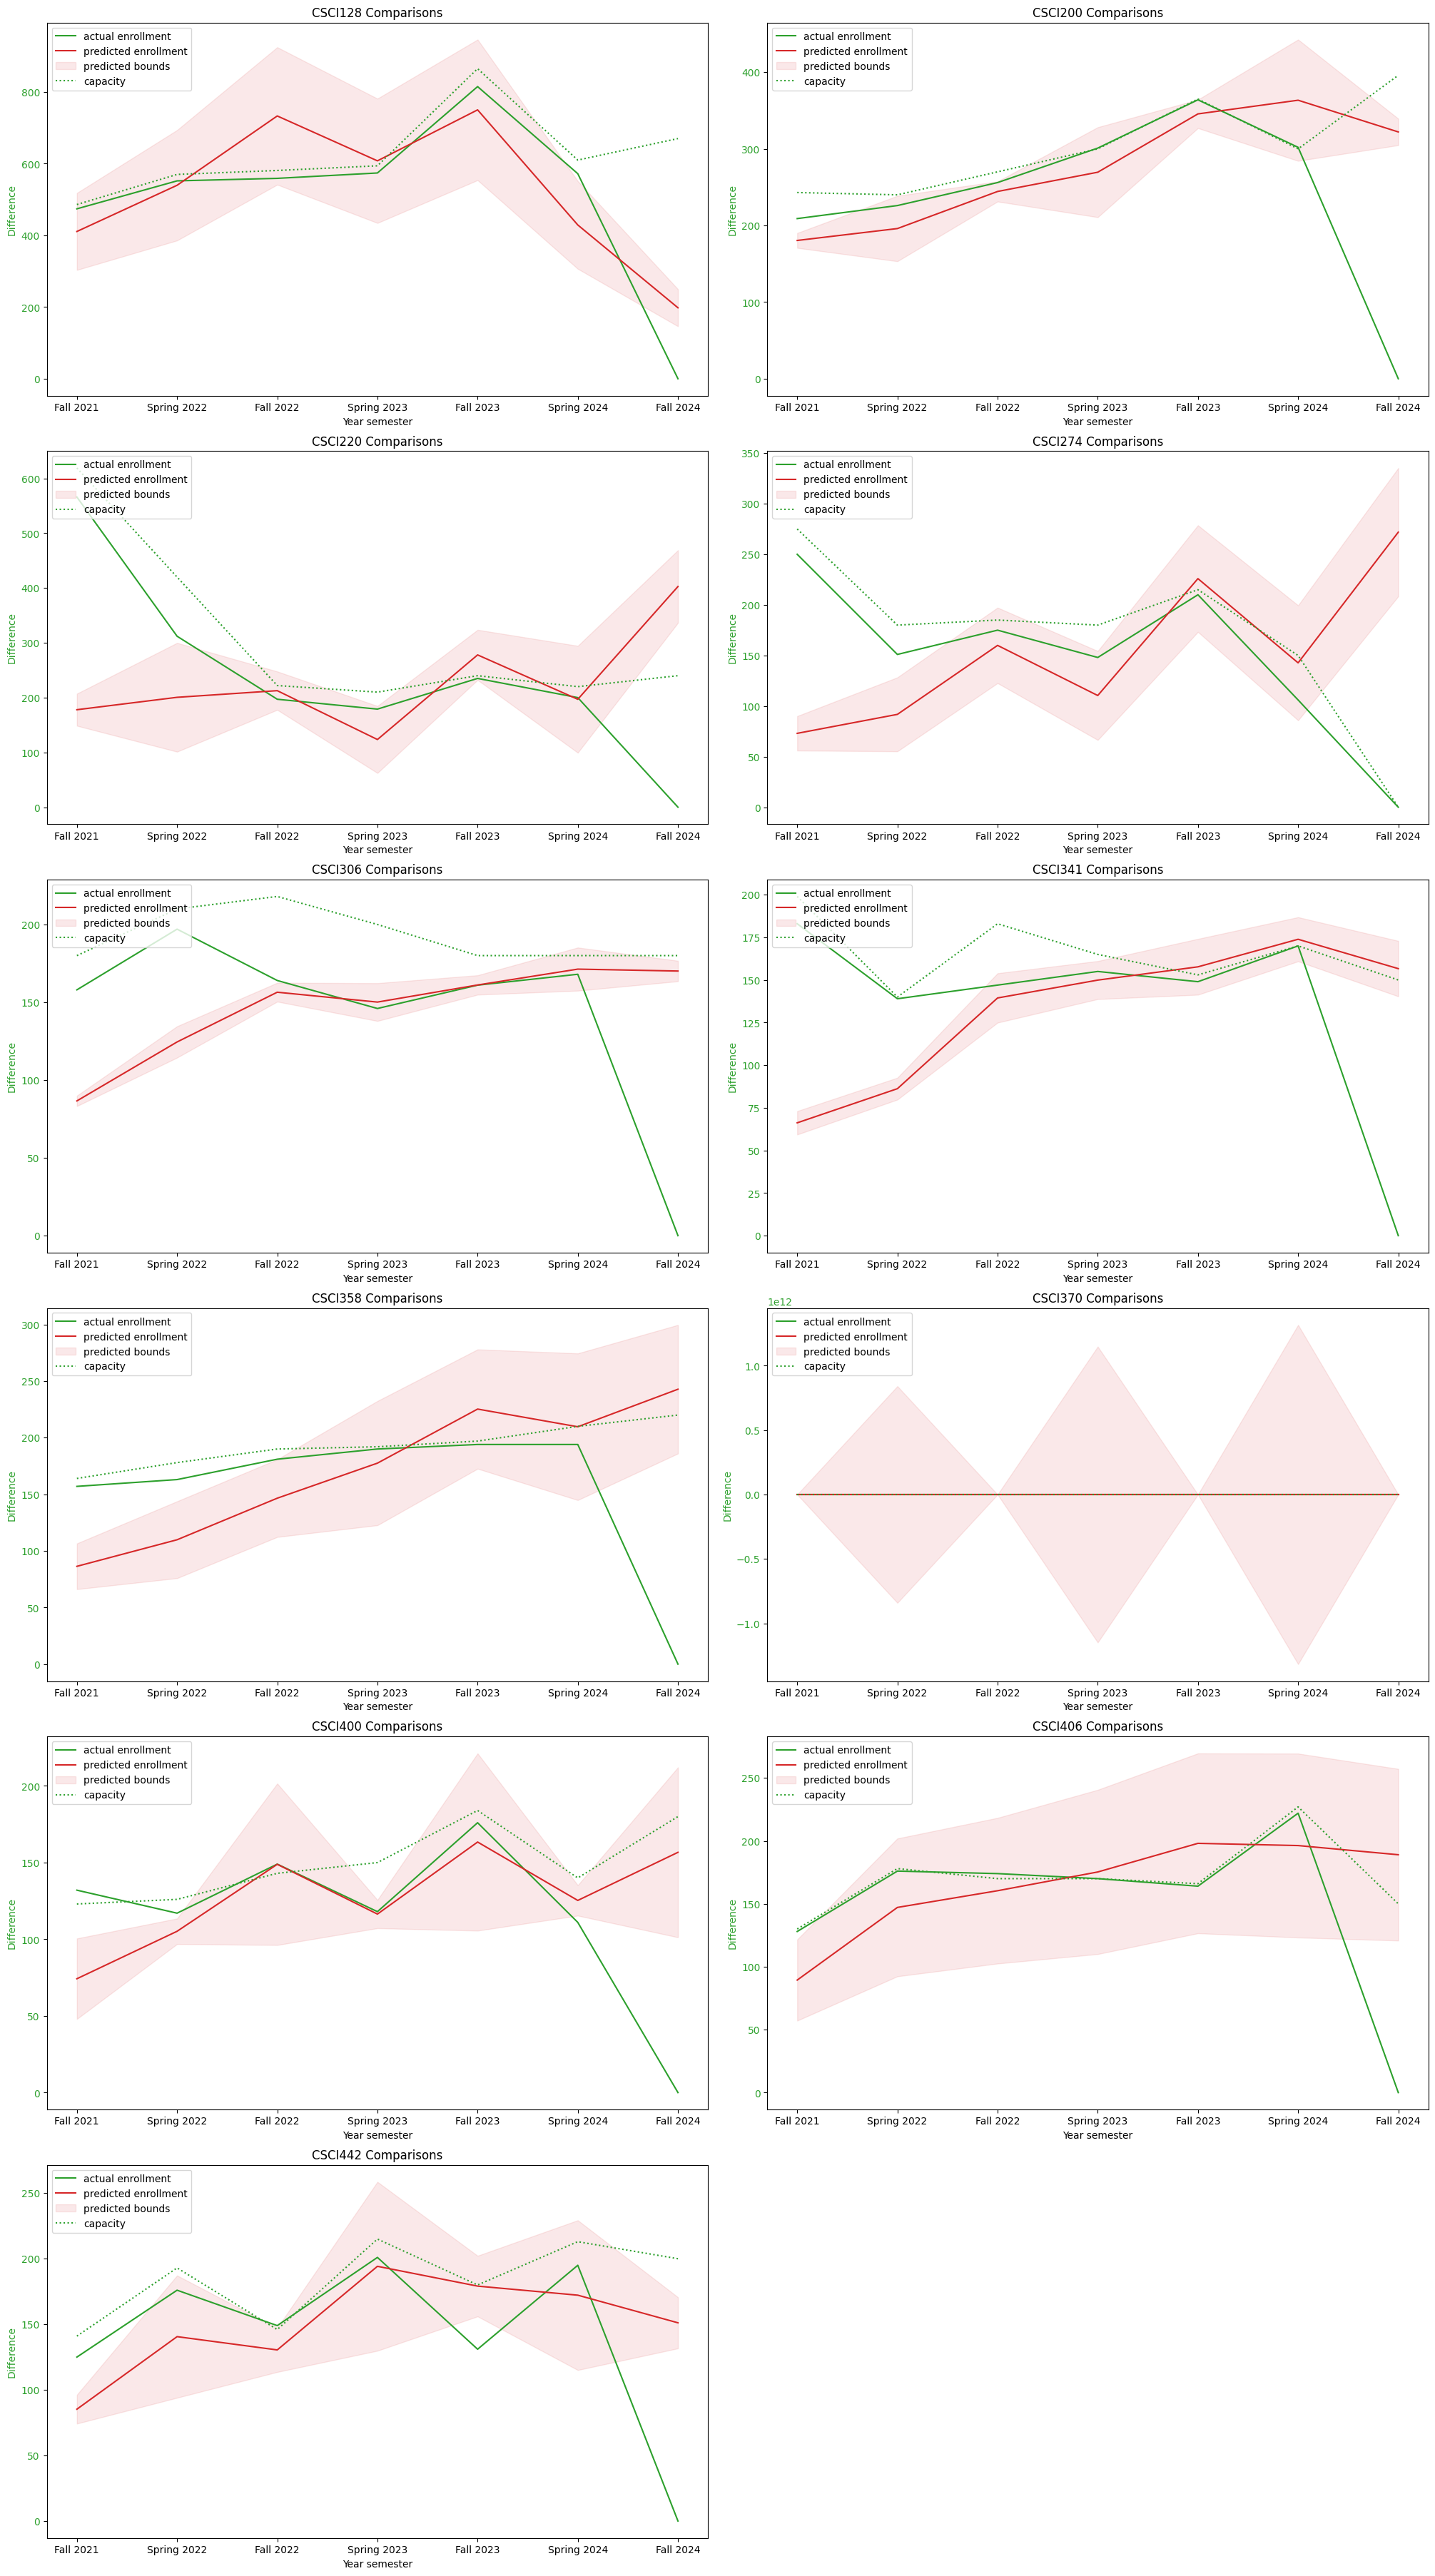

In [738]:
# Calculate the number of rows and columns for the subplot grid
num_classes = len(cs_classes)
num_rows = int(np.ceil(num_classes / 2))  # Adjust the divisor to change the number of columns

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()  # Flatten the array for easy iteration

for i, cl in enumerate(cs_classes):
    plot_df = results_df[results_df['class'] == cl]
    
    # Select the subplot for the current class
    ax1 = axs[i]

    # 

    # Plotting on the primary y-axis
    color = 'tab:green'
    ax1.set_xlabel('Year semester')
    ax1.set_ylabel('Difference', color=color)
    ax1.plot(plot_df['year_semester'], plot_df['actual enrollment'], color=color, label='actual enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['fudge_corrected_predicted_enrollment'], color='tab:red', label='predicted enrollment')

    # Fill the area between the upper and lower bounds
    ax1.fill_between(plot_df['year_semester'], plot_df['upper predicted enrollment'], plot_df['lower predicted enrollment'], 
                     color='tab:red', alpha=0.1, label='predicted bounds')

    ax1.plot(plot_df['year_semester'], plot_df['capacity'], color='tab:green', linestyle = 'dotted', label='capacity')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Creating a secondary y-axis for the current subplot
    # ax2 = ax1.twinx()
    # color = 'tab:blue'
    # ax2.set_ylabel('Error', color=color)
    # ax2.plot(plot_df['year_semester'], plot_df['error_corrected_error'], color=color, linestyle='dotted')
    # ax2.tick_params(axis='y', labelcolor=color)
    # ax2.set_ylim([-1, 1])

    # Set the title for the current subplot
    ax1.set_title(f"{cl} Comparisons")

# Hide unused subplots if the number of classes is odd
if num_classes % 2 != 0:
    axs[-1].axis('off')

# save figure at high quality
plt.savefig('../images/markov_predictions.png', dpi=300)

plt.show()

In [733]:
# turn fall 2025 data into dictionary of just class, predicted enrollment, upper, and lower bounds
fall25_df = results_df[results_df['year_semester'] == 'Fall 2024'][['class', 'fudge_corrected_predicted_enrollment', 'upper predicted enrollment', 'lower predicted enrollment']]
fall25_df = fall25_df.set_index('class')
fall25_dict = fall25_df.to_dict(orient='index')

In [737]:
for cl in fall25_dict: 
    print(f"{cl}: {round(fall25_dict[cl]['fudge_corrected_predicted_enrollment'])}")
    print(f"\tUpper: {round(fall25_dict[cl]['upper predicted enrollment'])}")
    print(f"\tLower: {round(fall25_dict[cl]['lower predicted enrollment'])}")


CSCI128: 198
	Upper: 250
	Lower: 146
CSCI200: 322
	Upper: 339
	Lower: 305
CSCI220: 403
	Upper: 469
	Lower: 336
CSCI274: 272
	Upper: 335
	Lower: 208
CSCI306: 170
	Upper: 177
	Lower: 163
CSCI341: 157
	Upper: 173
	Lower: 140
CSCI358: 243
	Upper: 300
	Lower: 186
CSCI370: 0
	Upper: 0
	Lower: 0
CSCI400: 157
	Upper: 212
	Lower: 101
CSCI406: 189
	Upper: 257
	Lower: 121
CSCI442: 151
	Upper: 171
	Lower: 132


If we had data from the semester directly before the semester we wish to predict, that would help a lot. We'd have solved the problem at this point. 